In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [36]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [37]:
len(words)

32033

In [38]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [40]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
# kaiming init
# https://pytorch.org/docs/stable/nn.init.html
# ((5/3) / ((n_embed * block_size) ** 0.5))
# we scale W1 by this number which is 0.3
# gain/sqrt(fan_in)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / ((n_embed * block_size) ** 0.5))
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


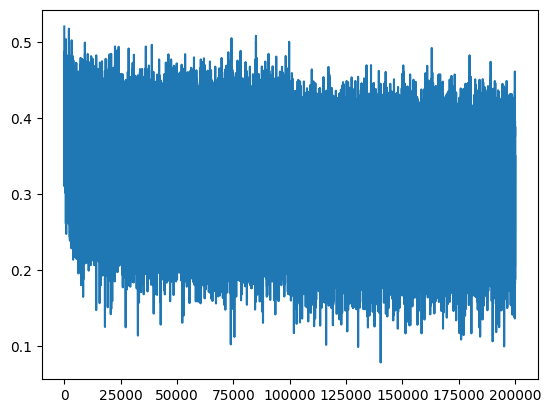

In [42]:
plt.plot(lossi)

In [43]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0376644134521484
val 2.106989622116089


In [44]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, n_embed)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.


In [45]:
# guassian distribution has a standard deviation of 1

torch.randn(10000).std()

tensor(1.0034)

In [46]:
# multiplying by a value < 1, scales down the standard deviation to that value

(torch.randn(10000) * 0.2).std()

tensor(0.2006)

In [47]:
# for our dataset we want to scale std deviation down to 0.3
# for tanh, gain = 5/3
# multiply by gain/sqrt(fan_in)


(5/3) / (30 ** 0.5)

0.3042903097250923

tensor(-0.0046) tensor(1.0012)
tensor(0.0048) tensor(3.1834)


(array([1.46657260e-05, 1.46657260e-05, 2.19985889e-05, 4.39971779e-05,
        1.02660082e-04, 1.31991534e-04, 3.44644560e-04, 4.76636094e-04,
        9.60605051e-04, 1.27591816e-03, 2.44184337e-03, 3.73976012e-03,
        5.77096317e-03, 8.40346098e-03, 1.30891604e-02, 1.88894550e-02,
        2.67942813e-02, 3.77349129e-02, 5.14766981e-02, 6.68023818e-02,
        8.58898241e-02, 1.02909399e-01, 1.21454210e-01, 1.31551562e-01,
        1.35877951e-01, 1.31602892e-01, 1.16387201e-01, 9.93969577e-02,
        8.07494872e-02, 6.42138811e-02, 4.86022158e-02, 3.43984603e-02,
        2.52397144e-02, 1.75475411e-02, 1.14612648e-02, 7.60417891e-03,
        4.99367969e-03, 3.13846536e-03, 1.92121010e-03, 1.30524961e-03,
        7.55284887e-04, 4.47304642e-04, 2.71315930e-04, 1.53990123e-04,
        3.66643149e-05, 9.53272188e-05, 1.46657260e-05, 0.00000000e+00,
        7.33286298e-06, 1.46657260e-05]),
 array([-16.62052536, -15.93866344, -15.25680153, -14.57493961,
        -13.8930777 , -13.2112

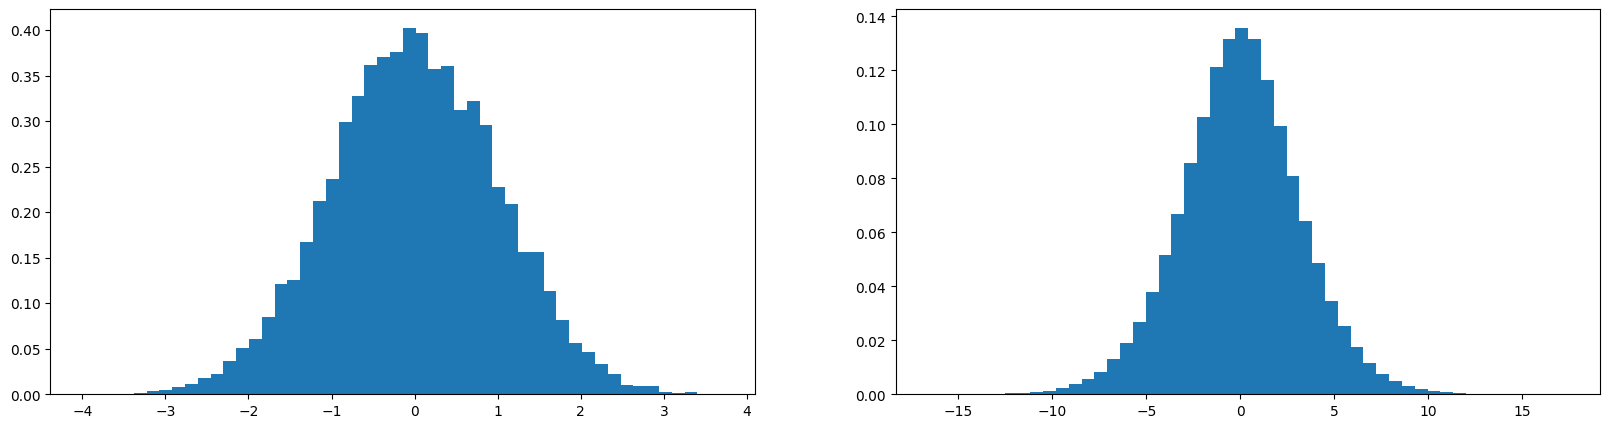

In [48]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) 

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # standard deviation increases
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(-0.0095) tensor(1.0093)
tensor(0.0011) tensor(0.6479)


(array([6.32668323e-05, 9.49002484e-05, 9.49002484e-05, 1.89800497e-04,
        9.49002484e-05, 4.42867826e-04, 5.69401490e-04, 7.27568571e-04,
        1.39187031e-03, 3.06844136e-03, 3.98581043e-03, 7.37058596e-03,
        1.00277929e-02, 1.56269076e-02, 2.85333413e-02, 4.27367452e-02,
        6.71577424e-02, 9.80635900e-02, 1.49657692e-01, 2.19124674e-01,
        3.02826693e-01, 4.06805731e-01, 5.25083074e-01, 6.26183472e-01,
        6.70723322e-01, 6.75310167e-01, 6.22703796e-01, 5.11227638e-01,
        4.00320881e-01, 3.03459361e-01, 2.13082691e-01, 1.46715784e-01,
        9.78737895e-02, 6.51648372e-02, 4.16928425e-02, 2.57812341e-02,
        1.67024437e-02, 9.61655850e-03, 6.48485031e-03, 4.30214459e-03,
        1.96127180e-03, 1.13880298e-03, 8.54102235e-04, 7.90835403e-04,
        4.11234410e-04, 2.53067329e-04, 6.32668323e-05, 3.16334161e-05,
        0.00000000e+00, 9.49002484e-05]),
 array([-3.94575763, -3.78769692, -3.62963622, -3.47157552, -3.31351481,
        -3.15545411, 

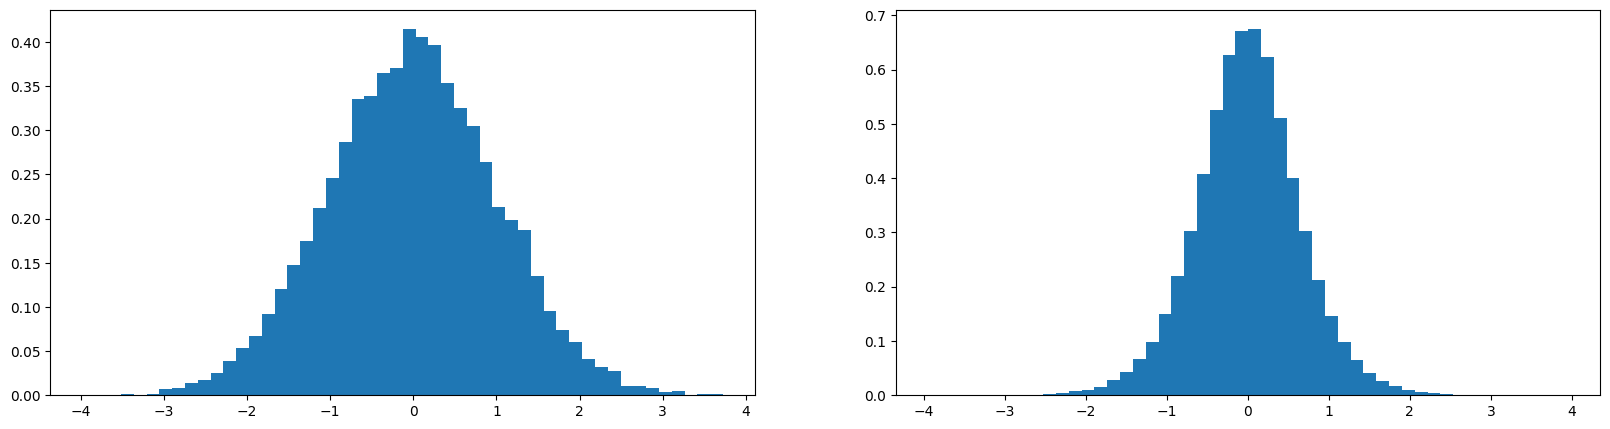

In [49]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(-0.0076) tensor(0.9983)
tensor(0.0003) tensor(0.9944)


(array([2.12531601e-05, 2.12531601e-05, 2.12531601e-05, 6.37594802e-05,
        2.12531601e-04, 2.12531601e-04, 4.88822682e-04, 5.31329002e-04,
        1.63649333e-03, 2.55037921e-03, 4.39940414e-03, 7.11980863e-03,
        1.12641748e-02, 1.80651861e-02, 2.89468040e-02, 4.36964971e-02,
        7.00929219e-02, 1.00293662e-01, 1.49218437e-01, 1.98589528e-01,
        2.67067210e-01, 3.29211450e-01, 3.83619539e-01, 4.27464809e-01,
        4.31417896e-01, 4.05340269e-01, 3.49508217e-01, 2.93739925e-01,
        2.24390864e-01, 1.61524017e-01, 1.16361051e-01, 8.03794514e-02,
        5.40467861e-02, 3.39200435e-02, 2.09131095e-02, 1.33894908e-02,
        8.33123875e-03, 5.31329002e-03, 2.91168293e-03, 1.87027809e-03,
        1.04140484e-03, 6.16341642e-04, 2.97544241e-04, 2.55037921e-04,
        1.48772121e-04, 2.12531601e-05, 2.12531601e-05, 2.12531601e-05,
        2.12531601e-05, 2.12531601e-05]),
 array([-5.68945169, -5.45419256, -5.21893343, -4.9836743 , -4.74841516,
        -4.51315603, 

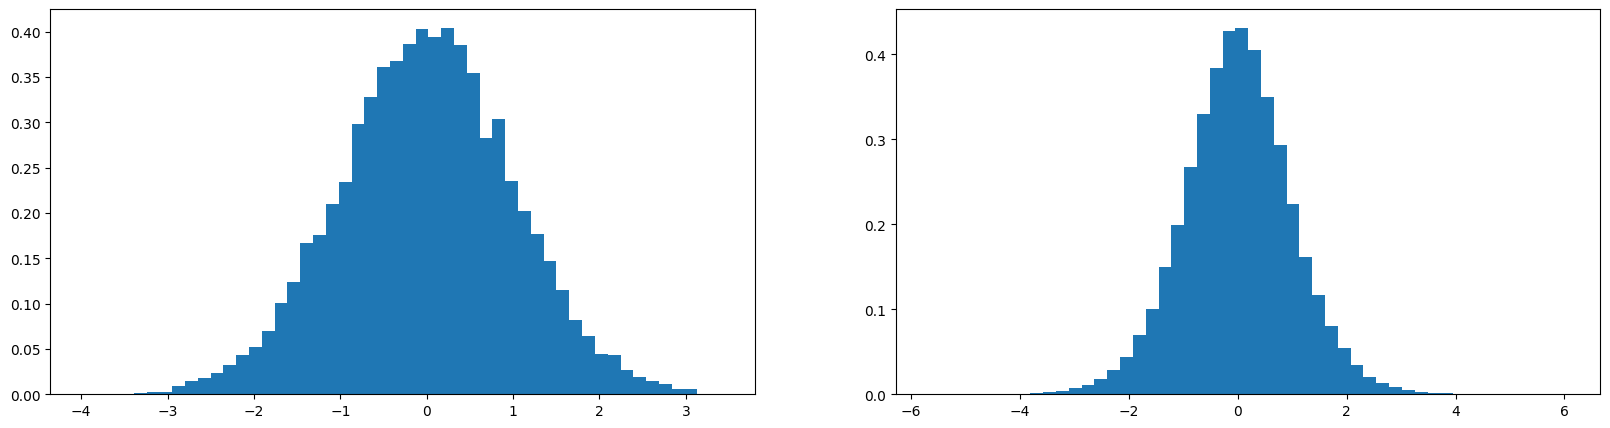

In [50]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
# for linear below works
# 1 / (sqrt(fan_in))

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)